Stability of defection, optimisation of strategies and the limits of memory in the PD.
-----------------------

## 1. Utility and Best responses to memory-one players

In [1]:
import opt_mo
import numpy as np
import sympy as sym

sym.init_printing()


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/envs/opt-mo/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import itertools
import axelrod as axl

from fractions import Fraction


In [3]:
import pandas as pd
from pathlib import Path

In [4]:
import matplotlib.pyplot as plt
import matplotlib


In [5]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)


In [6]:
p_1, p_2, p_3, p_4 = sym.symbols("p_1, p_2, p_3, p_4")
q_1, q_2, q_3, q_4 = sym.symbols("q_1, q_2, q_3, q_4")


In [7]:
p = (p_1, p_2, p_3, p_4)
q = (q_1, q_2, q_3, q_4)


Utility
-------

The markov chain $M$.

In [8]:
M = opt_mo.mem_one_match_markov_chain(player=p, opponent=q)


In [9]:
tex = Path.cwd().resolve().joinpath('tex')
img_path = Path.cwd().resolve().joinpath('img')


with open(tex.joinpath("m_matrix.tex"), "w") as f:
    f.write("M = {}".format(sym.latex(sym.Matrix(M))))


Let $v$ be the stationary vector of $M$, where $M$ is the transition matrix $M(p,q)$.

In [10]:
pi_1, pi_2, pi_3, pi_4 = sym.symbols("pi_1, pi_2, pi_3, pi_4")
pi = (pi_1, pi_2, pi_3, pi_4)


In [11]:
ss = opt_mo.steady_states(M, pi)


Once the markovian matrix is defined we can calculate the stable states of the matrix. 
The stable states multiplied  by the scores of each state return the score of a player. The payoff matrices for $X$ and $Y$ equivilant are: $S_{p} = (R, S, T, P)$ & $S_{q} = (R, S, T, P)$

In [12]:
v = sym.Matrix([[ss[pi_1]], [ss[pi_2]], [ss[pi_3]], [ss[pi_4]]])


In [13]:
R, S, T, P = sym.symbols("R, S, T, P")
payoffs = np.array([R, S, T, P])


In [14]:
utility = v.dot(np.array([3, 1, 5, 0]))

To test this we can have a defector play against a defector. We know that the score should be 1. Similar for two cooperators the score should be 3.

In [15]:
assert (
    utility.subs({p_1: 0, p_2: 0, p_3: 0, p_4: 0, q_1: 0, q_2: 0, q_3: 0, q_4: 0}) == 0
)
assert (
    utility.subs({p_1: 0, p_2: 0, p_3: 0, p_4: 0, q_1: 1, q_2: 1, q_3: 1, q_4: 1}) == 5
)
assert (
    utility.simplify().subs(
        {p_1: 1, p_2: 1, p_3: 1, p_4: 1, q_1: 1, q_2: 1, q_3: 1, q_4: 1}
    )
    == 3
)


**Comparison to Press and Dyson formulation.**

In Press and Dyson's work on their 2012 article. They have managed to prove
that:

 $$v \times S_{p} = \frac{D (p, q, S_{p})} {D (p, q, 1)}$$

where $D$ is a $4 \times 4$ the determinant of a defined matrix $B$.

In [16]:
S_p = sym.Matrix([[3, 1, 5, 0]])
B = opt_mo.make_B(S_p, (p_1, p_2, p_3, p_4), (q_1, q_2, q_3, q_4))


In [17]:
def pd_utility(S_p, x, y):
    """
    Returns the utility as a function
    of p, q vectors. Based on Press and Dyson, 2012.
    """
    B = sym.Matrix(opt_mo.make_B(S_p, x, y))
    unit = sym.Matrix(opt_mo.make_B((1, 1, 1, 1), x, y))
    return B.det() / unit.det()


In [18]:
x = (0, 0, 0, 0)
u = pd_utility(S_p, x, (q_1, q_2, q_3, q_4))


In [19]:
assert (
    u == utility.subs({S: 0, R: 3, T: 5, P: 1, p_1: 0, p_2: 0, p_3: 0, p_4: 0}).factor()
)



We have studied the numerator and the denominator of $u$ separately. 
Both the numerator and the denominator can be written as a general quadratic
form: 

 $$\frac{1}{2}pQp^T + c p^T + a$$


where $p$ is an $n \times 1$ column vector of variables, $Q$ is a symetric $n \times n$ matrix and a real-valued, $n$-dimensional vector $c$.

Thus the objective function $u$ is the fraction/ratio of the two quadratic forms.

Information on quadratic programming can be found [here](https://neos-guide.org/content/quadratic-programming,http://www.numerical.rl.ac.uk/people/nimg/qp/qp.html).

**Our formulation.**

In [20]:
utility = pd_utility(S_p, p, q)


In [21]:
numerator = sym.fraction(utility.simplify())[0]
denominator = sym.fraction(utility.simplify())[1]


**Numerator**

In [22]:
numerator

In [23]:
ps = np.array(p)
Q_num = np.array([[numerator.coeff(f1 * f2) for f2 in p] for f1 in p])
c_num = np.array(
    [
        numerator.subs({p_2: 0, p_3: 0, p_4: 0}).coeff(p_1),
        numerator.subs({p_1: 0, p_3: 0, p_4: 0}).coeff(p_2),
        numerator.subs({p_1: 0, p_2: 0, p_4: 0}).coeff(p_3),
        numerator.subs({p_1: 0, p_2: 0, p_3: 0}).coeff(p_4),
    ]
)


In [24]:
expr = np.dot(ps, Q_num.dot(ps.T) * 1 / 2) + np.dot(c_num, ps.T)
constant = numerator.expand() - expr


In [25]:
constant.factor()


In [26]:
assert (expr + constant).subs(
    {p_1: 0, p_2: 0, p_3: 0, p_4: 0, q_1: 1, q_2: 1, q_3: 1, q_4: 1}
) == 5


In [27]:
Q_num = sym.Matrix([[element.factor() for element in row] for row in Q_num])
c_num = sym.Matrix([element.factor() for element in c_num])


In [28]:
for file, name in zip(
    [Q_num, c_num, constant.simplify()],
    ["q_numerator", "c_numerator", "numerator_constant"],
):

    with open(tex / "{}.tex".format(name), "w") as f:
        f.write("{}".format(sym.latex(file)))


**Denominator**

In [29]:
Q_den = np.array([[denominator.coeff(f1 * f2) for f2 in p] for f1 in p])
c_den = np.array(
    [
        denominator.subs({p_2: 0, p_3: 0, p_4: 0}).coeff(p_1),
        denominator.subs({p_1: 0, p_3: 0, p_4: 0}).coeff(p_2),
        denominator.subs({p_1: 0, p_2: 0, p_4: 0}).coeff(p_3),
        denominator.subs({p_1: 0, p_2: 0, p_3: 0}).coeff(p_4),
    ]
)


In [30]:
expr = np.dot(ps, Q_den.dot(ps.T) * 1 / 2) + np.dot(c_den, ps.T)
den_constant = denominator.expand() - expr


In [31]:
assert (expr + den_constant).subs(
    {p_1: 0, p_2: 0, p_3: 0, p_4: 0, q_1: 1, q_2: 1, q_3: 1, q_4: 1}
) == 1


In [32]:
Q_den = sym.Matrix([[element.factor() for element in row] for row in Q_den])
c_den = sym.Matrix([element.factor() for element in c_den])


In [33]:
for file, name in zip(
    [sym.Matrix(Q_den), sym.Matrix(c_den), den_constant.simplify()],
    ["q_denominator", "c_denominator", "denominator_constant"],
):
    with open(tex / "{}.tex".format(name), "w") as f:
        f.write("{}".format(sym.latex(file)))


**Validation**

In [34]:
qs = [(1 / 3, 1 / 3, 1 / 3, i) for i in np.linspace(0, 1, 20)]


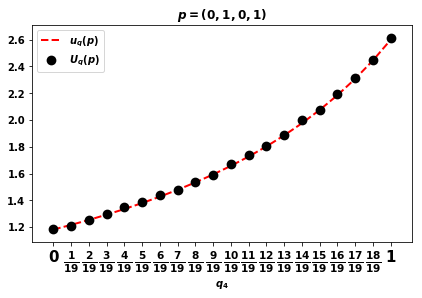

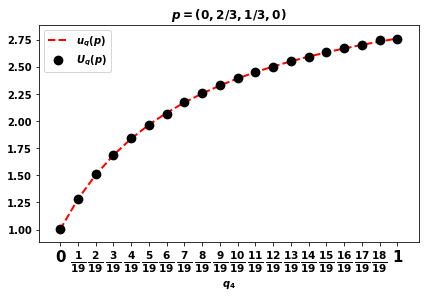

In [35]:
for p, filename in zip(
    [[0, 1, 0, 1], [0, 2 / 3, 1 / 3, 0]], ["against_player_one", "against_player_two"]
):

    theoritical = [opt_mo.match_utility(p, q) for q in qs]
    simulated = [opt_mo.simulate_match_utility(p, q) for q in qs]

    xlabels = [str(Fraction(i).limit_denominator()) for i in np.linspace(0, 1, 20)]
    xlabels[1:-1] = [
        r"$\frac{" + i.split("/")[0] + "}{" + i.split("/")[1] + "}$"
        for i in xlabels[1:-1]
    ]

    title = str([str(Fraction(i).limit_denominator()) for i in p])
    title = title.replace("[", "(").replace("]", ")").replace("'", "")

    plt.figure(figsize=[6.8, 4])
    plt.plot(
        range(len(theoritical)),
        theoritical,
        linestyle="--",
        color="red",
        linewidth=2,
        zorder=1,
        label="$u_q(p)$",
    )
    plt.scatter(
        range(len(simulated)),
        simulated,
        marker="o",
        s=60,
        color="black",
        zorder=2,
        label="$U_q(p)$",
        linewidth="2",
    )
    plt.title(r"$p={}$".format(title)), plt.legend()

    plt.xticks(range(len(theoritical)), xlabels, rotation=0, fontsize=15), plt.xlabel(
        r"$q_4$"
    )

    plt.savefig(img_path / ("validation_{}.pdf").format(filename), bbox_inches="tight")
    # plt.savefig(img_path.joinpath("validation_{}.pdf").read_text().format(filename)), bbox_inches="tight")


**Tournament Utility**

In [36]:
opponents = [(0, 0, 0, 0), (1, 0, 1, 0)]


In [37]:
-opt_mo.tournament_utility([1, 1, 1, 1], opponents)


**Stewart \& Plotkin tournament**

In [38]:
transitions = [
    (1, 1, 1, 1),
    (0, 0, 0, 0),
    (1 / 2, 1 / 2, 1 / 2, 1 / 2),
    (1, 0, 1, 0),
    (1, 0, 0, 0),
    (1, 1 / 3, 1, 1 / 3),
    (1, 0, 0, 1),
    (1, 1 / 8, 1, 1 / 4),
    (8 / 9, 1 / 2, 1 / 3, 0),
    (0.9, 0, 0.9, 0),
]


In [39]:
ps = [(1 / 3, 1 / 3, 1 / 3, i) for i in np.linspace(0, 1, 20)]


In [40]:
simulated_scores = []
for player in ps:
    score = opt_mo.simulate_tournament_utility(
        player, transitions, turns=100, repetitions=20
    )
    simulated_scores.append(score)


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


/anaconda3/envs/opt-mo/lib/python3.7/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


In [41]:
theoretical_values = []
for player in ps:
    utility = opt_mo.tournament_utility(player, transitions)
    theoretical_values.append(utility)


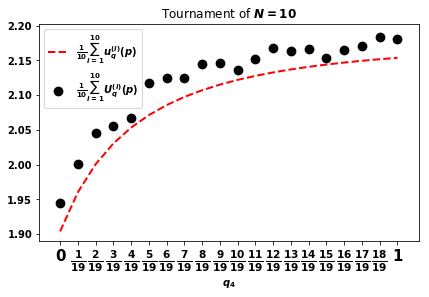

In [42]:
plt.figure(figsize=[6.8, 4])
plt.plot(
    theoretical_values,
    linestyle="--",
    color="red",
    linewidth=2,
    zorder=1,
    label=r"$\frac{1}{10} \sum_{i = 1} ^ {10} u_q^{(i)} (p)$",
)
plt.scatter(
    range(len(simulated_scores)),
    simulated_scores,
    marker="o",
    s=60,
    color="black",
    zorder=2,
    label=r"$\frac{1}{10} \sum_{i = 1} ^ {10} U_q^{(i)} (p)$",
    linewidth="2",
)
plt.legend()

plt.title("Tournament of $N=10$"), plt.legend()

xlabels = [str(Fraction(i).limit_denominator()) for i in np.linspace(0, 1, 20)]
xlabels[1:-1] = [
    r"$\frac{" + i.split("/")[0] + "}{" + i.split("/")[1] + "}$" for i in xlabels[1:-1]
]

plt.xticks(
    range(len(theoretical_values)), xlabels, rotation=0, fontsize=15
), plt.xlabel(r"$q_4$")

plt.savefig(img_path.joinpath("Stewart_tournament_results.pdf"), bbox_inches="tight")


In [43]:
players = [[Fraction(p[i]).limit_denominator() for p in ps] for i in range(4)]


In [44]:
table = pd.DataFrame(
    [
        players[0],
        players[1],
        players[2],
        players[3],
        simulated_scores,
        theoretical_values,
    ]
).transpose()


In [45]:
table.columns = [
    r"$p_1$",
    r"$p_2$",
    r"$p_3$",
    r"$p_4$",
    r"$\frac{1}{10} \sum\limits_{i = 1} ^ {10} u_q^{(i)} (p)$",
    r"$\frac{1}{10} \sum\limits_{i = 1} ^ {10} U_q^{(i)} (p)$",
]


In [46]:
table.head()


,$p_1$,$p_2$,$p_3$,$p_4$,$\frac{1}{10} \sum\limits_{i = 1} ^ {10} u_q^{(i)} (p)$,$\frac{1}{10} \sum\limits_{i = 1} ^ {10} U_q^{(i)} (p)$
0,1/3,1/3,1/3,0,1.94465,1.90388
1,1/3,1/3,1/3,1/19,2.0013,1.96031
2,1/3,1/3,1/3,2/19,2.0461,2.00053
3,1/3,1/3,1/3,3/19,2.0558,2.0304
4,1/3,1/3,1/3,4/19,2.0674,2.05327


In [47]:
textfile = open(tex.joinpath("stewart_plotkin_simulation.tex"), "w")
textfile.write(table.to_latex())
textfile.close()


**Mean player vs Average Utility**

In [48]:
p_one, p_two = np.linspace(0, 1, 50), np.linspace(0, 1, 50)


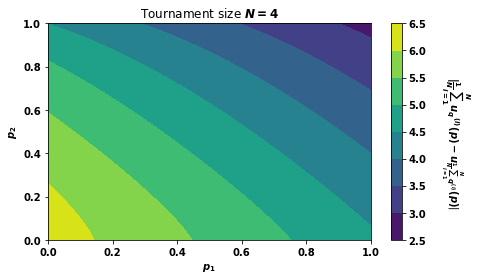

In [49]:
axl.seed(11)
opponents = [np.random.random(4) for _ in range(4)]
mean_player = [np.mean([opponents[i][j] for i in range(4)]) for j in range(4)]

av_utility = -opt_mo.tournament_utility((p_1, p_2, p_1, p_2), opponents)
mn_utility = opt_mo.match_utility((p_1, p_2, p_1, p_2), mean_player)

plt.figure(figsize=[6.8, 4])
expr = sym.lambdify((p_1, p_2), abs(av_utility - mn_utility).simplify())

X, Y = np.meshgrid(p_one, p_two)
Z = expr(X, Y)

plt.contourf(X, Y, Z)
cbar = plt.colorbar()
plt.title("Tournament size $N=4$"), plt.xlabel("$p_1$"), plt.ylabel("$p_2$")
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label(
    r"$|\frac{1}{N} \sum_{i=1} ^ {N} {u_q}^{(i)} (p) - u_{\frac {1}{N} \sum_{i=1} ^ N q^{(i)}}(p)$|",
    rotation=270,
    labelpad=+45,
    y=0.45,
)
plt.tight_layout()

plt.savefig(img_path.joinpath("mean_vs_average_heatmap.pdf"), bbox_inches="tight")
